# 1 标准化和预分词

在深入探讨 Transformer 模型常用的三种分词算法（字节对编码[BPE]、WordPiece 和 Unigram）之前，我们首先来看看 tokenizer 对文本进行了哪些预处理。以下是 tokenization 过程的高度概括：

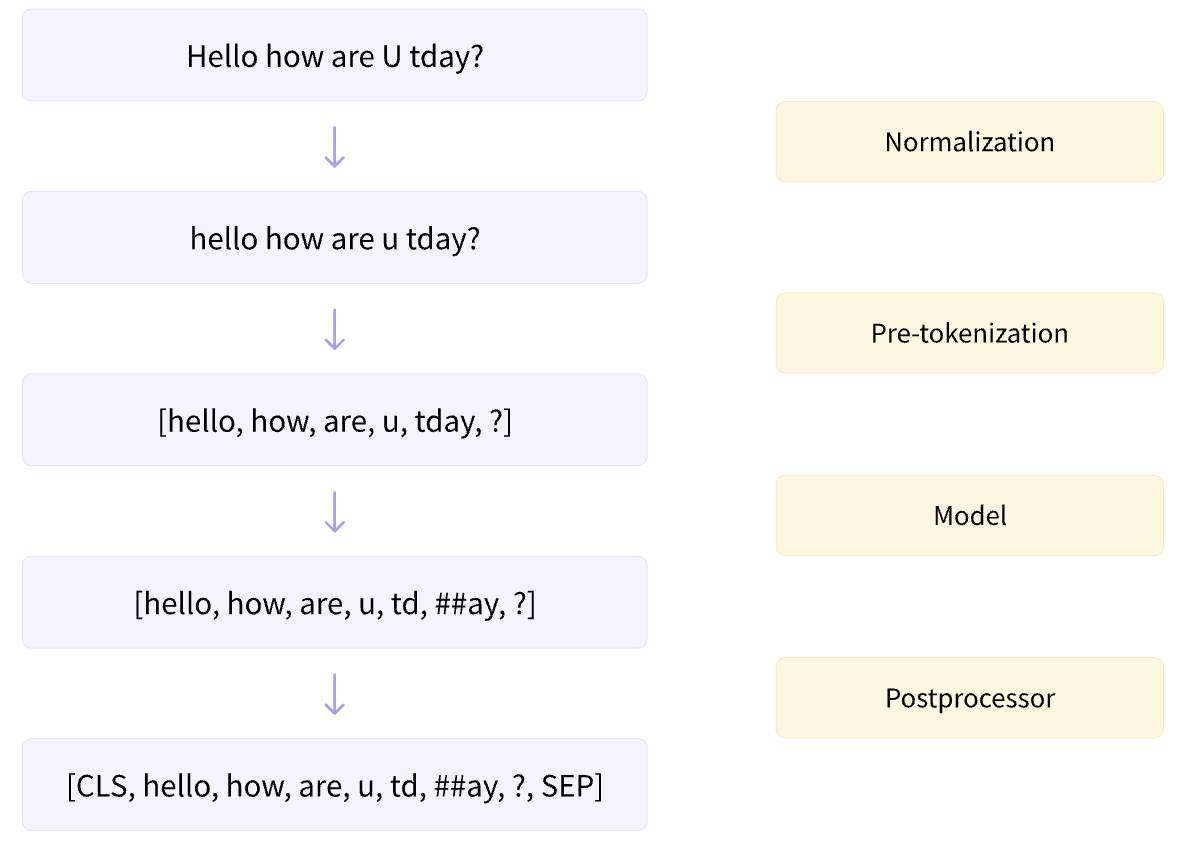

在分词（根据其模型）之前，tokenizer 需要进行两个步骤： 标准化（normalization） 和 预分词（pre-tokenization） 。

## 1.2 标准化

标准化步骤涉及一些常规清理，例如删除不必要的空格、小写和“/”或删除重音符号。如果你熟悉 Unicode 标准化 （例如 NFC 或 NFKC），那么这也是 tokenizer 可能会使用的东西。

🤗 Transformers 的 tokenizer 具有一个名为 backend_tokenizer 的属性，该属性可以访问来自🤗 Tokenizers 库的底层 tokenizer 。

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
type(tokenizer.backend_tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizers.Tokenizer

tokenizer 对象的 normalizer 属性具有一个 normalize_str() 方法，我们可以使用该方法查看如何进行标准化：

In [2]:
tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?")

'hello how are u?'

✏️ 试试看！ 从 bert-base-cased checkpoint 加载 tokenizer 并处理相同的示例。看一看 tokenizer 的 cased 和 uncased 版本之间的主要区别是什么？

In [3]:
cased_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
uncased_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [4]:
cased_tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?")

'Héllò hôw are ü?'

In [6]:
uncased_tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?")

'hello how are u?'

## 1.2 预分词

要查看快速 tokenizer 如何执行预分词，我们可以使用 tokenizer 对象的 pre_tokenizer 属性的 pre_tokenize_str() 方法：

In [7]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

请注意 tokenizer 记录了偏移量，这是就是我们在前一节中使用的偏移映射。在这里 tokenizer 将两个空格并将它们替换为一个，从 are 和 you 之间的偏移量跳跃可以看出来这一点。

由于我们使用的是 BERT tokenizer 所以预分词会涉及到在空白和标点上进行分割。其他的 tokenizer 可能会对这一步有不同的规则。例如，如果我们使用 GPT-2 的 tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('Ġ', (14, 15)),
 ('Ġyou', (15, 19)),
 ('?', (19, 20))]

也请注意，与 BERT tokenizer 不同的是，这个 tokenizer 不会忽略双空格。

最后一个例子，让我们看一下基于 SentencePiece 算法的 T5 tokenizer

In [9]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

现在我们对一些不同的 tokenizer 如何处理文本有了一些了解，接下来我们就可以开始探索底层算法本身。我们将先简要了解一下广泛适用的 SentencePiece；然后，在接下来的三节中，我们将研究用于子词分词的三种主要算法的工作原理。

---

# 2 SentencePiece

SentencePiece 是一种用于文本预处理的 tokenization 算法，你可以将其与我们将在接下来的三个部分中看到的任何模型一起使用。它将文本视为 Unicode 字符序列，并用特殊字符 ▁ 替换空格。与 Unigram 算法结合使用（参见 第七节 ）时，它甚至不需要预分词步骤，这对于不使用空格字符的语言（如中文或日语）非常有用。

SentencePiece 的另一个主要特点是可逆 tokenization：由于没有对空格进行特殊处理，解码 tokens 的时候只需将它们连接起来，然后将 _ 替换为空格，就可以还原原始的文本。如我们之前所见，BERT tokenizer 会删除重复的空格，所以它的分词不是可逆的。

---

# 3 算法概述

在下面的部分中，我们将深入研究三种主要的子词 tokenization 算法：BPE（由 GPT-2 等使用）、WordPiece（由 BERT 使用）和 Unigram（由 T5 等使用）。在我们开始之前，先来快速了解它们各自的工作方式。如果你还不能理解，不妨在阅读接下来的每一节之后返回此表格进行查看。

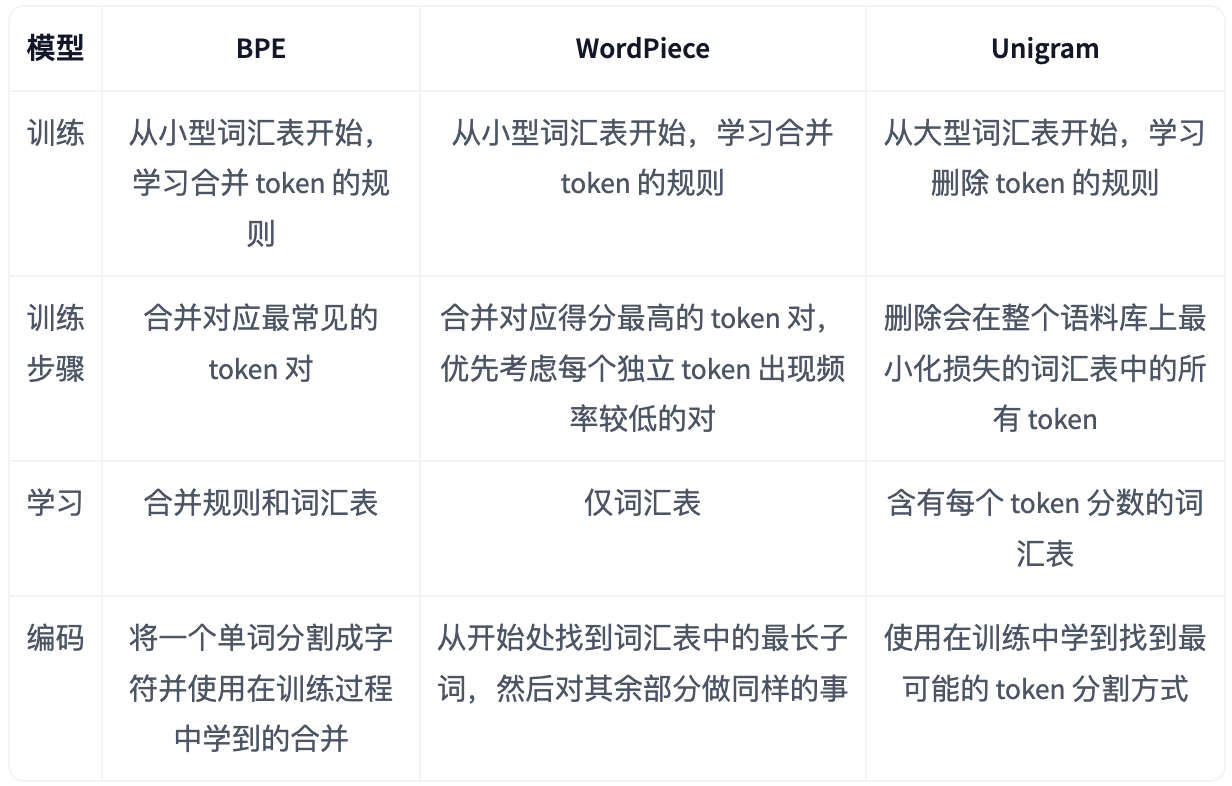